In [16]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

tf version 2.1.0 executing eagerly is True
tfp version 0.9.0


In [17]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

#raw_val = raw_test.shard(2,0)
#raw_test = raw_test.shard(2,1)

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#parsed_val = raw_val.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

latent_dim = 100

In [23]:
class Recognizer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Recognizer, self).__init__()
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
 
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim)
        ], name="encoder")

        self.comparer = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name="comparer")

    
    @tf.function
    def recognize(self, a, b):
        a_encoding = self.encode(a)
        b_encoding = self.encode(b)

        return self.decide(a_encoding, b_encoding)
    
    @tf.function
    def encode(self, x):
        encoding = self.encoder(x)
        return encoding

    @tf.function
    def decide(self, a_enc, b_enc):
        diffs = tf.abs(a_enc - b_enc)
        prediction = self.comparer(diffs)
        return prediction

recognizer = Recognizer(latent_dim)
recognizer.load_weights(BASE_DIR + 'saved_model/recognizerWeights')

In [0]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=918273645)

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim, kernel_initializer=init), # no activation...
        ], name="encode")
    
    @tf.function
    def __call__(self, x):
        mean, logvar = tf.split(self.encode(x), num_or_size_splits=2, axis=1)
        return mean, logvar


class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="decode")

    @tf.function
    def __call__(self, x):
        return self.decode(x)


@tf.function
def reparameterize(mean, logvar):
    # Logvar used for numerical stability
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean

@tf.function
def generateImg(enc, dec, x):
    mean, logvar = enc(x)
    return generateDist(dec, mean, logvar)

@tf.function
def generateDist(dec, mean, logvar):
    z = reparameterize(mean, logvar)
    return dec(z)

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, kernel_initializer=init),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init),
        ], name="discriminate")
    
    @tf.function
    def __call__(self, x):
        return self.discriminate(x)


In [0]:
encOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
decOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
disOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))
N = tf.convert_to_tensor(IMG_HEIGHT * IMG_WIDTH, dtype=tf.float32)
M = tf.convert_to_tensor(BATCH_SIZE, dtype=tf.float32)
reconstructionMult = tf.math.divide(N, M)


@tf.function
def compute_apply_gradients(enc, dec, dis, x_neutral, x_express, x_other, encOptimizer, decOptimizer, disOptimizer, alpha, beta, gamma):
    # Watch any trainable variables for automatic differentiation
    with tf.GradientTape(persistent=True) as tape:
        encloss, decloss, disloss = compute_loss(enc, dec, dis,
                                                 x_neutral, x_express, x_other,
                                                 alpha, beta, gamma)

    gradients_of_enc = tape.gradient(encloss, enc.trainable_variables)
    gradients_of_dec = tape.gradient(decloss, dec.trainable_variables)
    gradients_of_dis = tape.gradient(disloss, dis.trainable_variables)

    encOptimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    decOptimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    disOptimizer.apply_gradients(zip(gradients_of_dis, dis.trainable_variables))


#@tf.function
def compute_loss(enc, dec, dis, x_neutral, x_express, x_other, alpha, beta, gamma):
    #Compute loss values
    klLoss, recLoss, decGanLoss, disGanLoss, idLoss = compute_ALL_loss(enc, dec, dis,
                                                        x_neutral, x_express, x_other)

    idLoss  = tf.math.multiply(alpha, idLoss)

    # Group them up for each network
    encLoss = tf.math.add(tf.math.multiply(beta,  klLoss), recLoss) # (B * Lkl) + Lrec
    decLoss = tf.math.add(tf.math.multiply(gamma, recLoss), decGanLoss) # (G * Lrec) - Lgan
    disLoss = disGanLoss

    return encLoss, decLoss, disLoss


#@tf.function
def compute_ALL_loss(enc, dec, dis, x_neutral, x_express, x_other):
    mean_e, logvar_e = enc(x_express)
    #print("ENCODING: {0} {1}".format(mean_e, logvar_e))

    # KL Divergence Loss
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, logvar_e)
    divergenceLoss = tf.reduce_mean(tfp.distributions.kl_divergence(posterior, prior))

    #print("DL: {0}".format(divergenceLoss))

    generated_images = generateDist(dec, mean_e, logvar_e)

    # Reconstruction Loss
    reconstructionLoss = tf.math.multiply(reconstructionMult, tf.math.sqrt(tf.reduce_mean(tf.math.square(tf.math.subtract(x_neutral, generated_images)))))

    # Let the discriminator discriminate
    real_decisions = dis(x_neutral)
    fake_decisions = dis(generated_images)
    samples = tf.random.normal(shape=[generated_images.shape[0], latent_dim])
    sample_decisions = dis(dec(samples))

    # Discriminator-based Loss
    genGanLoss, disGanLoss = compute_gan_loss(real_decisions, fake_decisions, sample_decisions)

    # Loss from not preserving identity
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    identityScores = recognizer.recognize(x_express, generated_images)
    identityLoss = cross_entropy(tf.ones_like(identityScores), identityScores)

    return divergenceLoss, reconstructionLoss, genGanLoss, disGanLoss, identityLoss


#@tf.function
def compute_gan_loss(real_output, fake_output, sample_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    # Loss from identitifation of real images
    dis_real_loss = cross_entropy(real_labels, real_output) # Try not to be fooled
    
    # Loss from identitifation of fake images
    gen_fake_loss = cross_entropy(real_labels, fake_output) # Try to fool
    dis_fake_loss = cross_entropy(fake_labels, fake_output) # Try not to be fooled
    
    # Loss from identitifation of fake sampled images
    gen_sample_loss = cross_entropy(real_labels, sample_output) # Try to fool
    dis_sample_loss = cross_entropy(fake_labels, sample_output) # Try not to be fooled
    
    # For generator: FakeLoss + SampleLoss
    gen_gan_loss = tf.math.add(gen_fake_loss, gen_sample_loss)
    # For discriminator: RealLoss + FakeLoss + SampleLoss
    dis_gan_loss = tf.math.add(tf.math.add(dis_real_loss, dis_fake_loss), dis_sample_loss)

    return gen_gan_loss, dis_gan_loss



In [0]:
epochs = 150
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]

encoder = Encoder(100)
decoder = Decoder(100)
discriminator = Discriminator()

In [0]:
# setup checkpoint stuff
checkpoint_dir = BASE_DIR + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encOptimizer=encOptimizer,
                                 decOptimizer=decOptimizer,
                                 disOptimizer=disOptimizer,
                                 encoder=encoder,
                                 decoder=decoder,
                                 discriminator=discriminator)

In [0]:
def save_images(epoch, test_input):
    imgs = decoder(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    ds = discriminator(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def display_discrim_images(imgs, dis):
    fig = plt.figure(figsize=(4,4))
    ds = discriminator(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def display_imgs_ratings(test_input, epoch=-1):
    images = generateImg(encoder, decoder, test_input[0:8])
    rs = recognizer.recognize(test_input[0:8], images)
    ims = np.concatenate((test_input[0:8], images), axis=0)
    assert not np.any(np.isnan(ims))
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(11,4))
    ds = discriminator(ims)
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        if r == 1:
            axes[r, c].set_title("d {0:.6f}\nr {1:.4f}".format(ds[i,0], rs[c,0]))
        else: 
            axes[r, c].set_title("d {0:.6f}".format(ds[i,0]))
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_ratings_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

def plot_ALL_loss(ls):
    kl, rl, gl, dl, il = zip(*ls)
    fig = plt.figure()
    plt.plot(kl, '-b', label='kL')
    plt.plot(rl, '-g', label='rL')
    plt.plot(gl, '-r', label='gL')
    plt.plot(dl, '-m', label='dL')
    plt.plot(il, '-y', label='iL')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 24, Losses: k 18.61234 r 22.38479 g 4.76976 d 0.70475 i 0.00000,
Total epoch time 84.9
Alpha: 0.000, Beta: 2.000, Gamma: 0.250


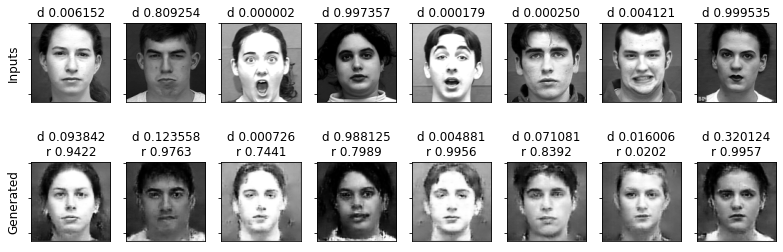

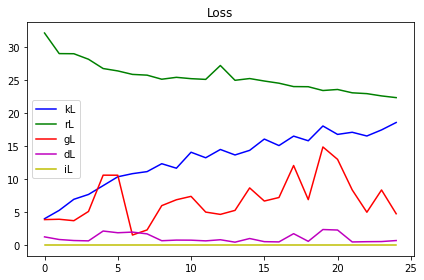


Training

In [0]:
# Save image for pre-training
alpha = 0.0
max_alpha = 10.0
alpha_ramp_start = 30
alpha_ramp_end = 50

beta = 0.0
max_beta = 2.0
beta_ramp_start = -1
beta_ramp_end = 15

gamma = tf.convert_to_tensor(0.25, dtype=tf.float32)

ls = []
bestLoss = 999999.9
for epoch in range(0, epochs):

    # Train
    print("\nTraining", end="")
    start_time = time.time()
    batchCounter = 0
    alpha = min(max_alpha, max_alpha * (max(0,(epoch - alpha_ramp_start)) / alpha_ramp_end))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    beta = min(max_beta, max_beta * (max(0, (epoch - beta_ramp_start)) / beta_ramp_end))
    beta = tf.convert_to_tensor(beta, dtype=tf.float32)
    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        #assert not np.any(np.isnan(neutral_raw))
        expressive_raw = image_features['imageExpressive']
        #assert not np.any(np.isnan(expressive_raw))
        other_raw = image_features['imageOther']
        #assert not np.any(np.isnan(other_raw))

        compute_apply_gradients(
            encoder, decoder, discriminator,
            neutral_raw, expressive_raw, other_raw,
            encOptimizer, decOptimizer, disOptimizer,
            alpha, beta, gamma)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting", end="")
    batchCounter = 0
    kloss = tf.keras.metrics.Mean()
    rloss = tf.keras.metrics.Mean()
    gloss = tf.keras.metrics.Mean()
    dloss = tf.keras.metrics.Mean()
    iloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        kl, rl, gl, dl, il = compute_ALL_loss(
            encoder, decoder, discriminator,
            neutral_raw, expressive_raw, other_raw)
        
        kloss(kl)
        rloss(rl)
        gloss(gl)
        dloss(dl)
        iloss(il)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    kl = tf.math.multiply(kloss.result(), beta).numpy()
    rl = tf.math.multiply(rloss.result(), gamma).numpy()
    gl = gloss.result().numpy()
    dl = dloss.result().numpy()
    il = tf.math.multiply(iloss.result(), alpha).numpy()
    ls = ls + [(kl, rl, gl, dl, il)]
    
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, Losses: k {1:.5f} r {2:.5f} g {3:.5f} d {4:.5f} i {5:.5f},\nTotal epoch time {6:.1f}'.format(
            epoch, kl, rl, gl, dl, il, end_time-start_time))
    print("Alpha: {0:.3f}, Beta: {1:.3f}, Gamma: {2:.3f}".format(alpha, beta, gamma))
    display_imgs_ratings(random_images_for_generation)    
    save_images(epoch, random_vector_for_generation)
    plot_ALL_loss(ls)

    # Save the model from time to time or if you get a new record
    if rl + gl < bestLoss:
        bestLoss = rl + gl
        best_checkpoint_prefix = os.path.join(checkpoint_dir, "BEST_CKPT_")
        checkpoint.save(file_prefix=best_checkpoint_prefix)
        print("*Saved new best*")
    elif (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    tf.keras.backend.clear_session()

In [0]:
checkpoint_prefix = os.path.join(checkpoint_dir, "FINAL_CKPT_" + time.strftime('%l:%M%b%d'))
checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
anim_filename = BASE_DIR + 'TrainingGifs/vaegan' + time.strftime('%l:%M %b %d') + '.gif'
print(anim_filename)
with imageio.get_writer(anim_filename, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)